# Exercise 1

## Physics 7810
## Due March 2, 2020

## E1.1 - Metropolis Monte Carlo simulation of the Lennard-Jones system

Write a Python program to simulate the three-dimensional (3D) Lennard-Jones (LJ) system in the $NVT$ ensemble using the Metropolis Monte Carlo (MC) algorithm. As in Homework 2, use periodic boundary conditions, and assume that the $N$ particles in the simulation are initially placed in a cubic box of sidelength $L$ (so the volume $V = L^3$).

You can re-use much of the molecular dynamics (MD) simulation code you wrote to simulate the 3D LJ system. The main difference is that the MD integration step for updating particle positions and velocities is replaced by an MC 'sweep' that updates particle positions through a sequence of $N$ small random displacements of randomly selected particles. There's no need to define the particle velocities in an MC simulation, as only particle configurations are sampled.

Note also that only changes in energy (not forces) are needed for calculating the Metropolis acceptance probability,

$$
P_\mathrm{acc}(o \to n) = \min \left[1, e^{- \beta \Delta U} \right].
$$

Thus, you could in principle save time by only computing the pair potential, not the pair forces. However, the pair forces are needed for calculating the pressure (via the virial), so keep the pair force calculation in your pair interaction routine.

Generate random trial moves for particles according to the procedure described in Section 3.3 in Frenkel and Smit and Section 4.4 in Allen and Tildesley. This involves generating a trial displacement of a selected particle uniformly within a cube of sidelength $\Delta$ centered on the particle. The parameter $\Delta$ is a free parameter that can be adjusted to maximize the sampling efficiency of the MC procedure. We'll discuss how to do this systematically later (see Section 3.3 in Frenkel and Smit, for example), but for now just adjust $\Delta$ so that the average acceptance probability is between $0.2$ and $0.5$ (note that the value of $\Delta$ needed to achieve this will depend on density and temperature).

Is it obvious that this procedure for generating trial displacements satisfies detailed balance?

Use your simulation code to reproduce the equation of state $\langle P(\rho) \rangle$ shown on the right side of Figure 3.5 in Frenkel and Smit, using the procedure described in Section 3.4 of Frenkel and Smit (cutoff $r_c$ equal to half the box length, tail corrections for the potential energy and pressure, etc.). Use Equation 3.4.1 to calculate the pressure from the virial (Equation 3.4.2). This will require accumulating the virial within your pair interaction routine.

Because you're using Python and an inefficient neighbor search method, you may need to simulate systems that are significantly smaller than the system studied by Frenkel and Smit ($N = 500$). Also, you'll need to monitor the equilibration of the system to determine at what point the potential energy and pressure have stabilized, with small fluctuations around a average value. Do this by plotting $U(n)$ and $P(n)$ as a function of the number of MC sweeps $n$. The average potential energy per particle $\langle U / N \rangle$ and the average pressure $\langle P \rangle$ should be calculated as averages over the latter part of the simulation, not including the initial approach to equilibrium.

### Solution

#### Part 1: The total potential energy and pressure as a function of time and the calculation of $\langle U/N \rangle$ and $\langle P \rangle$

According the Frenkel and Smit, the tail corrections for the energy and the pressure can be expressed as follows:

$$u^{\text{tail}} = \frac{8}{3} \pi \rho \left [ \frac{1}{3} \left ( \frac{1}{r_{c}} \right )^{9} - \left ( \frac{1}{r_{c}} \right )^{3} \right ], \; P^{\text{tail}} = \frac{16}{3} \pi \rho^{2} \left [ \frac{2}{3} \left ( \frac{1}{r_{c}} \right )^{9} - \left ( \frac{1}{r_{c}} \right )^{3} \right ]$$

In addition, the pressure can be calculated using virial:
$$P = \frac{\rho}{\beta} + \frac{\text{vir}}{V}$$
where the virial is defined by
$$\text{vir} = \frac{1}{3} \sum_{i} \sum_{j>i} {\bf f}({\bf r}_{ij}) \cdot {\bf r}_{ij}$$
As the virial is just one third the value of the sum of the dot product of the forces and the coordinates of all the pairs, instead of using a double loop, we can use `itertools.combination` to speed up the calculation. Also note that in a Monte Carlo simulation, only one particle is selected to be moved. Therefore, instead of computing the total energy of the system, we compute the total pairwise potential of the selected particle before and after the move is accepted and use the difference between these two values to compute the acceptance ratio. The computational cost should be lower than computing the total energy of the system.


Adding the methods decribed above, to run an MC simulation, we first have to import the library for molecular simulations, `Molecular_Simulations.py`.

In [1]:
import sys
sys.path.insert(1, '../')  # so the system can locate the library folder
from CompPhysLib.Molecular_Simulations import *

Then, we read the parameters for running the MC simulation from `Exercise_01.yml` and use the instance of the class `Initialization` as the input of `MonteCarlo` as follows. The parameters specified include:
```yaml
# Simulation parameters
simulation: 'MC'
N_particles: 10
N_steps: 50000
print_freq: 1

dimension: 3
box_length: 3
temperature: 0.9
coords_method: 'random'
PBC: 'yes'
max_d: 0.1

kb: 1
m: 1   # the mass of the particles (all the same)
potential: 'LJ'
epsilon: 1  # epsilon in LJ potential
sigma: 1    # signma in LJ potential
energy_truncation: 'yes'
r_c: 1.5
tail_correction: 'yes'
MC_E_total: 'yes'
```

In [9]:
%%prun
import time
t1 = time.time()
param = Initialization('Exercise_01.yml')
param.rho = 0.9
MC = MonteCarlo(param)
MC.MC_E_total = 'no'
MC.metropolis_algrtm(MC.coords)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

In MC: 0.9
In MC: 2.231443166940565
In Init: 0.9
In Init: 2.231443166940565
In MC: 0.9
In MC: 2.231443166940565
Elapsed time: 133.0579526424408
 

In [7]:
param = Initialization('Exercise_01.yml')
param.rho = 0.1
MC = MonteCarlo(param)

In MC: 0.1
In MC: 2.231443166940565
In Init: 0.1
In Init: 2.231443166940565
In MC: 0.1
In MC: 2.231443166940565


In [4]:
MC.rho

0.1

After the simulation is complete, we use `TrajAnalysis` to analyze the trajectory as follows.

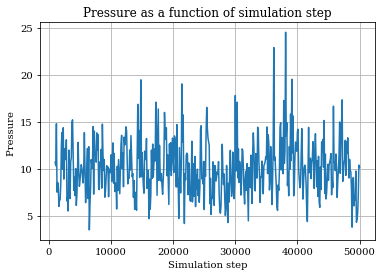

In [10]:
TA = TrajAnalysis(MC, 'Exercise_01_traj.yml')
#TA.plot_2d(TA.E_total, 'Total energy')
TA.plot_2d(TA.pressure, 'Pressure', 10)

In [18]:
#print('The average energy per particle is: %s' % (np.mean(np.array(TA.E_total[400:]) / TA.N_particles)))
print('The average pressure is: %s' % (np.mean(TA.pressure[400:])))

The average pressure is: 14.504610034765818


In [19]:
vars(MC)

{'param': {'simulation': 'MC',
  'N_particles': 10,
  'N_steps': 50000,
  'print_freq': 100,
  'dimension': 3,
  'rho': 0.9,
  'temperature': 2,
  'coords_method': 'random',
  'PBC': 'yes',
  'max_d': 0.1,
  'kb': 1,
  'm': 1,
  'potential': 'LJ',
  'epsilon': 1,
  'sigma': 1,
  'energy_truncation': 'yes',
  'tail_correction': 'yes',
  'MC_E_total': 'yes'},
 'simulation': 'MC',
 'N_particles': 10,
 'N_steps': 50000,
 'print_freq': 100,
 'dimension': 3,
 'rho': 0.1,
 'temperature': 2,
 'coords_method': 'random',
 'PBC': 'yes',
 'max_d': 0.12,
 'kb': 1,
 'm': 1,
 'potential': 'LJ',
 'epsilon': 1,
 'sigma': 1,
 'energy_truncation': 'yes',
 'tail_correction': 'yes',
 'MC_E_total': 'no',
 'box_length': 2.231443166940565,
 'shift_energy': 'no',
 'r_c': 1.1157215834702825,
 'prefix': 'Exercise_01',
 'traj_name': 'Exercise_01_traj.yml',
 'coords': array([[ 0.27519649, -0.80482628,  0.37056459],
        [ 0.9821591 , -0.3212578 ,  0.97077306],
        [-0.92628255,  1.11254135, -0.7409647 ],
  

#### Part 2: Pressure as a function of the density

In [5]:
def pressure_rho(temp, rho_list):
    param = Initialization('Exercise_01.yml')
    param.temperature = temp
    P = []
    for i in rho_list:
        param.rho = i
        MC = MonteCarlo(param)
        MC.MC_E_total = 'no'
        MC.metropolis_algrtm(MC.coords)
        TA = TrajAnalysis(MC, 'Exercise_01_traj.yml')
        P.append(TA.pressure)
        
    return P

In [6]:
t1 = time.time()
rho_list = np.arange(0.1, 1.0, 0.1)
P = pressure_rho(2, rho_list)
t2 = time.time()
print('Elapsed time: %s' % (t2-t1))

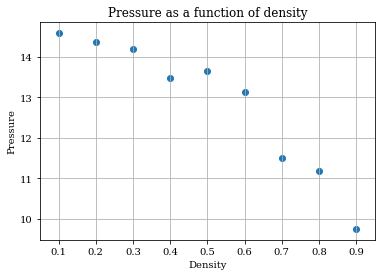

In [10]:
P_mean = []
for i in range(len(P)):
    P_mean.append(np.mean(P[i][400:]))

plt.figure()
plt.scatter(rho_list, P_mean)
plt.xlabel('Density')
plt.ylabel('Pressure')
plt.title('Pressure as a function of density')
plt.grid()

In [8]:
vars(MC)

{'param': {'simulation': 'MC',
  'N_particles': 10,
  'N_steps': 50000,
  'print_freq': 100,
  'dimension': 3,
  'rho': 0.9,
  'temperature': 2,
  'coords_method': 'random',
  'PBC': 'yes',
  'max_d': 0.1,
  'kb': 1,
  'm': 1,
  'potential': 'LJ',
  'epsilon': 1,
  'sigma': 1,
  'energy_truncation': 'yes',
  'tail_correction': 'yes',
  'MC_E_total': 'yes'},
 'simulation': 'MC',
 'N_particles': 10,
 'N_steps': 50000,
 'print_freq': 100,
 'dimension': 3,
 'rho': 0.9,
 'temperature': 2,
 'coords_method': 'random',
 'PBC': 'yes',
 'max_d': 0.12,
 'kb': 1,
 'm': 1,
 'potential': 'LJ',
 'epsilon': 1,
 'sigma': 1,
 'energy_truncation': 'yes',
 'tail_correction': 'yes',
 'MC_E_total': 'no',
 'box_length': 2.231443166940565,
 'shift_energy': 'no',
 'r_c': 1.1157215834702825,
 'prefix': 'Exercise_01',
 'traj_name': 'Exercise_01_traj.yml',
 'coords': array([[-0.84237027, -0.08407582, -0.71746452],
        [ 0.30309824, -0.60039174, -0.84618287],
        [ 1.02676816, -1.06727707, -0.16258968],
  

2.231443166940565